# Iris Flower Classification

**supervised learning** problem using a **Neural Network** built in **PyTorch**.

**Features**
- Sepal Length (cm)
- Sepal Width (cm)
- Petal Length (cm)
- Petal Width (cm)

# Pipeline
1. Load and explore the dataset
2. **Preprocess** — 3-way split (Train 60% / Validation 20% / Test 20%) + StandardScaler normalisation
3. Convert data to PyTorch tensors
4. Build a neural network
5. **Train** the model (with per-epoch validation)
6. **Evaluate** — Validation set performance, then final Test set performance
7. Make new predictions


## Step 1 — Import Libraries


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
import matplotlib.pyplot as plt
import itertools

torch.manual_seed(42)
np.random.seed(42)

print('Libraries imported successfully!')
print(f'PyTorch version: {torch.__version__}')

Libraries imported successfully!
PyTorch version: 2.10.0+cpu


## Step 2 — Load and Explore the Dataset


In [2]:
# Load the Iris dataset
iris = load_iris()
X = iris.data    # Feature matrix: shape (150, 4)
y = iris.target  # Labels: 0, 1, or 2

print('--- Dataset Info ---')
print(f'Total samples     : {X.shape[0]}')
print(f'Number of features: {X.shape[1]}')
print(f'Feature names     : {iris.feature_names}')
print(f'Class names       : {iris.target_names.tolist()}')
print(f'Class distribution: {dict(zip(iris.target_names, np.bincount(y)))}')

print('\n--- First 5 Samples ---')
print('Features (X):')
print(X[:5])
print('Labels (y):', y[:5])

--- Dataset Info ---
Total samples     : 150
Number of features: 4
Feature names     : ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Class names       : ['setosa', 'versicolor', 'virginica']
Class distribution: {np.str_('setosa'): np.int64(50), np.str_('versicolor'): np.int64(50), np.str_('virginica'): np.int64(50)}

--- First 5 Samples ---
Features (X):
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
Labels (y): [0 0 0 0 0]


## Step 3 — Visualize the Data



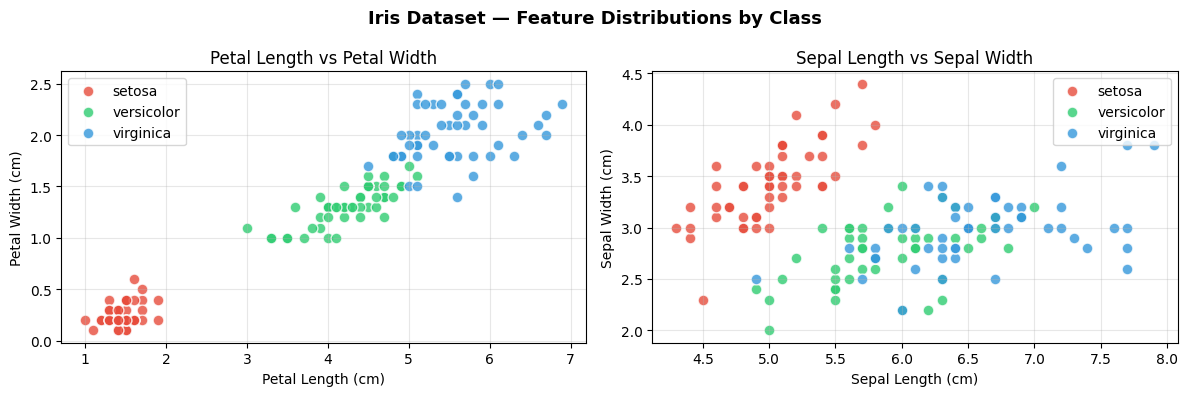

In [3]:
colors = ['#e74c3c', '#2ecc71', '#3498db']
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for cls in range(3):
    mask = y == cls
    axes[0].scatter(X[mask, 2], X[mask, 3], c=colors[cls],
                    label=iris.target_names[cls], alpha=0.8, edgecolors='white', s=60)
axes[0].set_xlabel('Petal Length (cm)')
axes[0].set_ylabel('Petal Width (cm)')
axes[0].set_title('Petal Length vs Petal Width')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for cls in range(3):
    mask = y == cls
    axes[1].scatter(X[mask, 0], X[mask, 1], c=colors[cls],
                    label=iris.target_names[cls], alpha=0.8, edgecolors='white', s=60)
axes[1].set_xlabel('Sepal Length (cm)')
axes[1].set_ylabel('Sepal Width (cm)')
axes[1].set_title('Sepal Length vs Sepal Width')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Iris Dataset — Feature Distributions by Class', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 4 — Preprocess the Data

In [4]:
# ── 1. First split off the test set (20%) ───────────────────────────────
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# ── 2. Split the remainder into train (75% of temp = 60% total)
#         and validation (25% of temp = 20% total) ────────────────────────
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print('── Split Summary ──────────────────────────────')
print(f'Training   set: {len(X_train):3d} samples  ({100*len(X_train)/len(X):.0f}%)')
print(f'Validation set: {len(X_val):3d} samples  ({100*len(X_val)/len(X):.0f}%)')
print(f'Test       set: {len(X_test):3d} samples  ({100*len(X_test)/len(X):.0f}%)')

# ── 3. Normalise — fit ONLY on train, apply to val & test ────────────────
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

print(f'\nAfter scaling — Training data stats:')
print(f'  Mean : {X_train.mean(axis=0).round(3)}')
print(f'  Std  : {X_train.std(axis=0).round(3)}')


── Split Summary ──────────────────────────────
Training   set:  90 samples  (60%)
Validation set:  30 samples  (20%)
Test       set:  30 samples  (20%)

After scaling — Training data stats:
  Mean : [-0.  0. -0.  0.]
  Std  : [1. 1. 1. 1.]


## Step 5 — Convert to PyTorch Tensors & Create DataLoaders

We create three sets of tensors and DataLoaders: **train**, **validation**, and **test**.


In [5]:
# Convert numpy arrays → PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_val_t   = torch.tensor(y_val,   dtype=torch.long)
y_test_t  = torch.tensor(y_test,  dtype=torch.long)

print(f'X_train_t : {X_train_t.shape}  y_train_t : {y_train_t.shape}')
print(f'X_val_t   : {X_val_t.shape}    y_val_t   : {y_val_t.shape}')
print(f'X_test_t  : {X_test_t.shape}   y_test_t  : {y_test_t.shape}')

# DataLoaders for mini-batch training
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset   = TensorDataset(X_val_t,   y_val_t)
test_dataset  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False)

sample_X, sample_y = next(iter(train_loader))
print(f'\nOne mini-batch — X: {sample_X.shape}, y: {sample_y.shape}')


X_train_t : torch.Size([90, 4])  y_train_t : torch.Size([90])
X_val_t   : torch.Size([30, 4])    y_val_t   : torch.Size([30])
X_test_t  : torch.Size([30, 4])   y_test_t  : torch.Size([30])

One mini-batch — X: torch.Size([16, 4]), y: torch.Size([16])


## Step 6 — Build the Neural Network

In [6]:
class IrisNet(nn.Module):
    """
    A simple 3-layer feedforward neural network for Iris classification.
    Architecture: 4 -> 16 -> 8 -> 3
    """
    def __init__(self, input_dim=4, hidden1=16, hidden2=8, output_dim=3):
        super(IrisNet, self).__init__()

        # Fully connected layers
        self.fc1 = nn.Linear(input_dim, hidden1)   # Layer 1: 4 inputs  → 16 outputs
        self.fc2 = nn.Linear(hidden1,  hidden2)    # Layer 2: 16 inputs → 8  outputs
        self.fc3 = nn.Linear(hidden2,  output_dim) # Layer 3: 8 inputs  → 3  outputs (logits)

        # Activation function (applied after hidden layers)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Defines the forward pass — how data flows through the network.
        PyTorch automatically computes the backward pass using autograd.
        """
        x = self.relu(self.fc1(x))  # Hidden layer 1 + activation
        x = self.relu(self.fc2(x))  # Hidden layer 2 + activation
        x = self.fc3(x)             # Output layer (no activation — CrossEntropy handles it)
        return x

# Instantiate the model
model = IrisNet()

print('Model Architecture:')
print(model)
print(f'\nTotal trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

Model Architecture:
IrisNet(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=3, bias=True)
  (relu): ReLU()
)

Total trainable parameters: 243


## Step 7 — Define Loss Function & Optimizer

### Loss Function: `CrossEntropyLoss`

### Optimizer: `Adam`

In [7]:
# Loss function: Cross-Entropy for multi-class classification
#logits as input (not softmax probabilities)
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam with learning rate 0.01
# model.parameters() gives Adam access to all trainable weights & biases
optimizer = optim.Adam(model.parameters(), lr=0.01)

print(f'Loss function : {criterion}')
print(f'Optimizer     : {optimizer.__class__.__name__}')
print(f'Learning rate : {optimizer.param_groups[0]["lr"]}')

Loss function : CrossEntropyLoss()
Optimizer     : Adam
Learning rate : 0.01


## Step 8 — Train the Model (with Validation)

Each epoch:
1. **Train** on mini-batches (forward → loss → backward → update)
2. **Validate** on the held-out validation set (no gradient updates)

Tracking both curves helps detect overfitting early.


In [12]:
NUM_EPOCHS = 100
train_losses     = []
train_accuracies = []
val_losses       = []
val_accuracies   = []

print('Starting training...\n')

for epoch in range(1, NUM_EPOCHS + 1):

    model.train()
    epoch_loss = 0.0
    correct = 0
    total   = 0

    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss    = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * batch_X.size(0)
        correct    += (outputs.argmax(dim=1) == batch_y).sum().item()
        total      += batch_y.size(0)

    train_losses.append(epoch_loss / total)
    train_accuracies.append(correct / total * 100)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total   = 0

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs  = model(batch_X)
            loss     = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_X.size(0)
            val_correct += (outputs.argmax(dim=1) == batch_y).sum().item()
            val_total   += batch_y.size(0)

    val_losses.append(val_loss / val_total)
    val_accuracies.append(val_correct / val_total * 100)

    if epoch % 10 == 0:
        print(f'Epoch [{epoch:3d}/{NUM_EPOCHS}]  '
              f'Train Loss: {train_losses[-1]:.4f}  Train Acc: {train_accuracies[-1]:.1f}%  |  '
              f'Val Loss: {val_losses[-1]:.4f}  Val Acc: {val_accuracies[-1]:.1f}%')

print('\n Training complete!')


Starting training...

Epoch [ 10/100]  Train Loss: 0.0081  Train Acc: 100.0%  |  Val Loss: 0.4251  Val Acc: 93.3%
Epoch [ 20/100]  Train Loss: 0.0162  Train Acc: 98.9%  |  Val Loss: 0.3872  Val Acc: 93.3%
Epoch [ 30/100]  Train Loss: 0.0048  Train Acc: 100.0%  |  Val Loss: 0.4018  Val Acc: 93.3%
Epoch [ 40/100]  Train Loss: 0.0039  Train Acc: 100.0%  |  Val Loss: 0.4154  Val Acc: 93.3%
Epoch [ 50/100]  Train Loss: 0.0031  Train Acc: 100.0%  |  Val Loss: 0.4359  Val Acc: 93.3%
Epoch [ 60/100]  Train Loss: 0.0025  Train Acc: 100.0%  |  Val Loss: 0.4670  Val Acc: 93.3%
Epoch [ 70/100]  Train Loss: 0.0019  Train Acc: 100.0%  |  Val Loss: 0.4838  Val Acc: 93.3%
Epoch [ 80/100]  Train Loss: 0.0018  Train Acc: 100.0%  |  Val Loss: 0.5058  Val Acc: 93.3%
Epoch [ 90/100]  Train Loss: 0.0015  Train Acc: 100.0%  |  Val Loss: 0.5276  Val Acc: 93.3%
Epoch [100/100]  Train Loss: 0.0012  Train Acc: 100.0%  |  Val Loss: 0.5471  Val Acc: 93.3%

 Training complete!


## Step 9 — Visualize Training & Validation Progress

- **Loss curves** — should decrease; a widening gap between train and val signals overfitting.
- **Accuracy curves** — should increase; val accuracy shows generalisation performance.


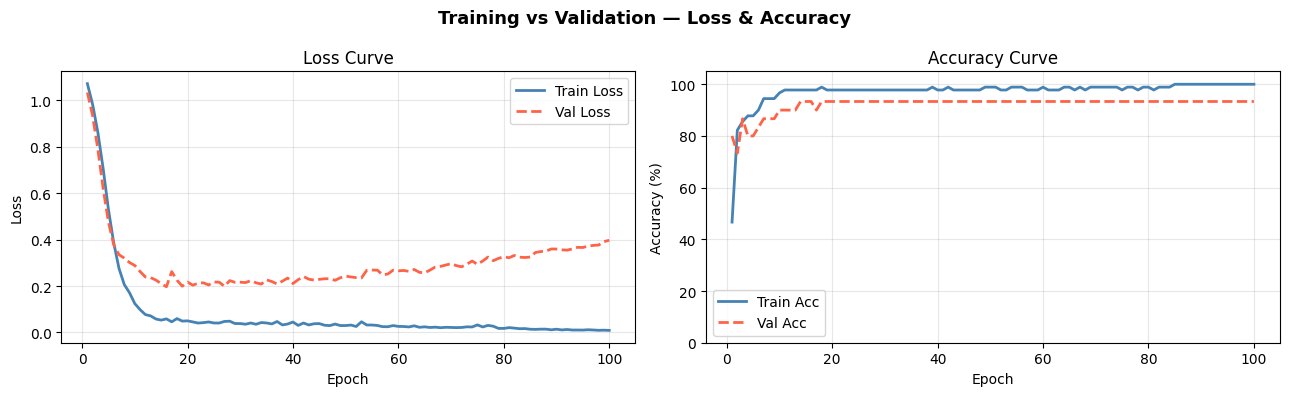

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

epochs = range(1, NUM_EPOCHS + 1)

ax1.plot(epochs, train_losses, color='steelblue', linewidth=2, label='Train Loss')
ax1.plot(epochs, val_losses,   color='tomato',    linewidth=2, label='Val Loss', linestyle='--')
ax1.set_title('Loss Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(epochs, train_accuracies, color='steelblue', linewidth=2, label='Train Acc')
ax2.plot(epochs, val_accuracies,   color='tomato',    linewidth=2, label='Val Acc', linestyle='--')
ax2.set_title('Accuracy Curve')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_ylim(0, 105)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Training vs Validation — Loss & Accuracy', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()


## Step 10 — Evaluate on Validation & Test Sets

We first confirm performance on the **validation set** (used to guide development),  
then report the **final test set** accuracy (unseen during training or tuning).


In [10]:
model.eval()

with torch.no_grad():
    val_outputs = model(X_val_t)
    val_preds   = val_outputs.argmax(dim=1)

val_acc = (val_preds == y_val_t).float().mean().item() * 100
print('── Validation Set ──────────────────────────────────')
print(f'Validation Accuracy : {val_acc:.1f}%')
print(f'Correctly classified: {(val_preds == y_val_t).sum().item()} / {len(y_val_t)} samples')

print()
print('Classification Report (Validation):')
print(classification_report(y_val_t.numpy(), val_preds.numpy(),
                             target_names=iris.target_names))

with torch.no_grad():
    test_outputs = model(X_test_t)
    test_preds   = test_outputs.argmax(dim=1)

test_acc = (test_preds == y_test_t).float().mean().item() * 100
print('── Test Set ────────────────────────────────────────')
print(f'Test Accuracy       : {test_acc:.1f}%')
print(f'Correctly classified: {(test_preds == y_test_t).sum().item()} / {len(y_test_t)} samples')

print()
print('Classification Report (Test):')
print(classification_report(y_test_t.numpy(), test_preds.numpy(),
                             target_names=iris.target_names))


── Validation Set ──────────────────────────────────
Validation Accuracy : 93.3%
Correctly classified: 28 / 30 samples

Classification Report (Validation):
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

── Test Set ────────────────────────────────────────
Test Accuracy       : 93.3%
Correctly classified: 28 / 30 samples

Classification Report (Test):
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.

## Step 11 — Make New Predictions (Inference)
1. Scale the raw input using the **same scaler** fitted on training data
2. Convert to a PyTorch tensor
3. Pass through the model to get logits
4. Apply **softmax** to get human-readable class probabilities
5. Take the `argmax` as the final prediction

In [11]:
def predict_flower(measurements, model, scaler, class_names):
    """
    Predict the iris species for a given set of measurements.

    Args:
        measurements: list of [sepal_len, sepal_wid, petal_len, petal_wid]
        model: trained IrisNet
        scaler: fitted StandardScaler
        class_names: list of class name strings
    """
    model.eval()

    # Step 1: Scale the input using the training scaler
    x = np.array([measurements])
    x_scaled = scaler.transform(x)

    # Step 2: Convert to tensor
    x_tensor = torch.tensor(x_scaled, dtype=torch.float32)

    # Step 3: Forward pass
    with torch.no_grad():
        logits = model(x_tensor)
        probs  = torch.softmax(logits, dim=1).squeeze().numpy()

    # Step 4: Get prediction
    pred_class = int(probs.argmax())

    print(f'Input: {measurements}')
    for i, (name, prob) in enumerate(zip(class_names, probs)):
        marker = '    PREDICTED' if i == pred_class else ''
        print(f'  {name:12s}: {prob:.3f}{marker}')

    return class_names[pred_class]


print('=== Prediction Examples ===\n')

print('Sample 1 (expected: Setosa):')
predict_flower([5.1, 3.5, 1.4, 0.2], model, scaler, iris.target_names)

print('\nSample 2 (expected: Versicolor):')
predict_flower([6.0, 2.9, 4.5, 1.5], model, scaler, iris.target_names)

print('\nSample 3 (expected: Virginica):')
predict_flower([6.9, 3.1, 5.4, 2.1], model, scaler, iris.target_names)

=== Prediction Examples ===

Sample 1 (expected: Setosa):
Input: [5.1, 3.5, 1.4, 0.2]
  setosa      : 1.000    PREDICTED
  versicolor  : 0.000
  virginica   : 0.000

Sample 2 (expected: Versicolor):
Input: [6.0, 2.9, 4.5, 1.5]
  setosa      : 0.000
  versicolor  : 0.999    PREDICTED
  virginica   : 0.001

Sample 3 (expected: Virginica):
Input: [6.9, 3.1, 5.4, 2.1]
  setosa      : 0.000
  versicolor  : 0.000
  virginica   : 1.000    PREDICTED


np.str_('virginica')